### create data from stock

In [178]:
"""class Stock_Model
predict stock with LSTM. 2 way to use:
------- 1st way: obtain trained model with data from markt ---------
1) create instance:            stock = Stock_Model()
2) load stock data from markt: stock.load_stock()
3) prepare data:               stock.set_working_data()
4) construct data:             stock.create_train_test_data()
5) construct model:            stock.create_LSTM_model()
6) compile model:              stock.compile_model()
7) start training model:       stock.train_model()
8) predict data:               stock.model_predict()
9) evaluate result:            stock.calculate_accuracy()
10)visual result:              stock.visual_result()
------- 2nd way: training model with saved training data ---------
1) create instance:            stock = Stock_Model()
2) load data from file:        stock.load_data_file()
3) construct model:            stock.create_LSTM_model()
4) compile model:              stock.compile_model()
5) start training model:       stock.train_model()
6) load scaler                 stock.load_scaler()
7) predict data:               stock.model_predict()
8) evaluate result:            stock.calculate_accuracy()
9) visual result:              stock.visual_result()
------- 3rd way: training model with new training data ---------
1) create instance:            stock = Stock_Model()
2) load stock data from markt: stock.load_stock()
3) prepare data:               stock.set_working_data()
4) load saved model:           stock.load_model()
5) load scaler                 stock.load_scaler()
6) predict data:               stock.model_predict()
7) evaluate result:            stock.calculate_accuracy()
8) visual result:              stock.visual_result()
------- 4th way: evaluate predicted data from load file ---------
1) create instance:            stock = Stock_Model()
2) load predicted data:        stock.load_predict_data()
3) evaluate data:              stock.evaluate_result()
"""
import os, json
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import Input, saving
from curl_cffi import requests
from sklearn.metrics import accuracy_score
from joblib import dump, load

SYMBOL = "IFX.DE"
HISTORY = "10y"

class Stock_Model:
    """
    class Stock_Model
    create model and train model using LTSM for stock markt
    param[stock] str: symbol of stock
    param[period] str: length of history of data to be loaded,
                        they are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
    param[interval] str: interval of data to be obtained, they are 1m, 2m, 5m, 15m, 
                        30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo                        
    """
    CLASSES = ["Bull", "Bear"]
    def __init__(self, stock, period, interval="1d", win_size=60, path='.', delay_days=3):
        self._stock = stock
        self._period = period
        self._interval = interval
        self._window_size = win_size # default 60 days
        self._path = path # path of saved file if saving or loading them by default name
        self._model_name = f"{self._stock}_{self._period}_{self._interval}_{self._window_size}"
        ### default all features
        self._base_features = np.array([['Open', 'High', 'Low', 'Close', 'Volume', "Dividends", "Stock Splits"]])
        self._features = []
        self._stock_data = None
        self._X_train = None
        self._Y_train = None
        self._X_test = None
        self._Y_test = None
        self._data = None
        self._model = None
        self._asumpt_delay_days = delay_days
        self._best_mse_day = -1
        self._best_mae_day = -1
        self._best_rmse_day = -1
        self._best_r2_day = -1
        self._best_direction_day = -1

    @property
    def model_name(self):
        return self._model_name
        
    @property
    def stock_data(self):
        return self._stock_data

    @property
    def test_data(self):
        if self._data is None:
            return None
        return self._data

    @property
    def test_data_num(self):
        if self._data is None:
            return 0
        return len(self._data)
        
    @property
    def features(self):
        if self._features is None:
            return self._base_features
        return self._features

    @property
    def window_size(self):
        return self._window_size

    @window_size.setter
    def window_size(self, ws):
        self._window_size = ws

    ### Step 1. obtain stock data from markt
    def load_stock(self, stock=None, period=None, interval=None):
        ## read stock data from stock markt
        self._stock = stock if stock is not None else self._stock
        self._period = period if period is not None else self._period
        self._interval = interval if interval is not None else self._interval    
        self.session = requests.Session(impersonate="chrome")
        self._stock_data = yf.Ticker(self._stock, session=self.session).history(period=self._period, interval=self._interval)
        self._features = None
        # self._data = self._stock_data ## used for prediction process

    ### Step 2. prepare data for training
    def set_working_data(self, start_feature=0, end_feature=5, remove_cols=["Dividends", "Stock Splits"]):
        self._features = np.array([self._base_features[0, start_feature:end_feature]])
        ### remove meaningless columns
        self._data = self._stock_data.drop(columns=remove_cols)
        # remove today data
        self._data = self._data[:-1]
        self._data = self.normalize_data(self._data)
    
    def normalize_data(self, data, save=True):
        self._scaler = MinMaxScaler(feature_range=(0, 1))
        self._scaler.fit(data)
        if save: # save scaler
            self.save_scaler()
        return self._scaler.transform(data)

    def _create_sequences(self):
        if self.test_data_num < self._window_size:
            raise ValueError("Too few number of data")
        X, Y = [], []
        for i in range(self.test_data_num - self._window_size):
            # Input: add all features: Open, High, Low, Close, Volume
            X.append(self._data[i:i+self._window_size, :]) 
            # Output: predict Close price
            Y.append(self._data[i+self._window_size, 3]) 
        return np.array(X), np.array(Y)

    ### Step 3. construct data for training
    def create_train_test_data(self, train_data_percentage=0.7, save=True):
        if self.test_data_num < self._window_size:
            raise ValueError("Too few number of data")
        if train_data_percentage >= 1.0:
            raise ValueError("Percent must less than 1.0")
        X, Y = self._create_sequences()
        split = int(train_data_percentage * len(X))
        self._X_train, self._X_test = X[:split], X[split:]
        self._Y_train, self._Y_test = Y[:split], Y[split:]
        if save: # save normalized train- and test- data
            self.save_train_data()
            
    ### Step 4. construct test model
    def create_LSTM_model(self, load_data_file=None, save=True):
        input_layer = Input(shape=(self._X_train.shape[1], self._X_train.shape[2]))
        self._model = Sequential([
            input_layer,
            LSTM(64, return_sequences=True),  # 输入维度为 (窗口大小, 特征数)
            Dropout(0.3),
            LSTM(32, return_sequences=False),
            Dropout(0.2),
            Dense(1)
        ])
        '''self._model = Sequential()
        self._model.add(Input(shape=(self._X_train.shape[1], self._X_train.shape[2])))
        self._model.add(LSTM(64, return_sequences=True, self._X_train.shape[2])))
        self._model.add(Dropout(0.3))
        self._model.add(LSTM(32, return_sequences=False))
        self._model.add(Dropout(0.2))
        self._model.add(Dense(1))'''
        if save: # save model
            self.save_model()

    ### Step 5. compile model for training
    def compile_model(self, optim='adam', loss='mse'):
        self._model.compile(optimizer=optim, loss=loss)

    ### Step 6. start training
    def train_model(self, early_stop=True, monitor="val_loss", patience=10, epochs=100, batch_size=32):
        callback=[]
        if early_stop:
            cb_early_stop = EarlyStopping(monitor=monitor, patience=patience)
            callback.append(cb_early_stop)
        self._history = self._model.fit(
            self._X_train, self._Y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(self._X_test, self._Y_test),
            callbacks=callback,
            verbose=1
        )

    ### Step 7. predict data with the trained model
    def model_predict(self):
        '''
        model_predict
        predict data
        param[data] data to be predicted. if it is None, use test data in the model instance
        param[raw_data] boolean: True, data should be normalized, otherwise False
        '''
        if self._model is None:
            print("Warning: model is None. It must be created or loaded!")
            return
        self._Y_predict = self._model.predict(self._X_test)
        self._Y_pred_actual = self.invert_normalized_data(self._Y_predict)
        # 真实值反归一化
        self._Y_test_actual = self.invert_normalized_data(self._Y_test)

    def invert_normalized_data(self, data):
        # 反归一化需要重建完整的多变量矩阵（仅Close列有值，其他列置0）
        dummy_matrix = np.zeros((len(data), self.features.shape[1]))
        dummy_matrix[:, 3] = data.flatten()  # 第4列是Close
        return self._scaler.inverse_transform(dummy_matrix)[:, 3]

    ### Step 8. show result
    def visual_result(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self._Y_test_actual, label='True Close Price')
        plt.plot(self._Y_pred_actual, label='Predicted Close Price', alpha=0.7, linestyle='--')
        plt.title('Multivariate LSTM Stock Price Prediction')
        plt.xlabel('Time Step')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    #######################################################################################
    def train_model_with_actual_data(self):
        '''
        train_model_with_actual_data
        the connection to stock yahoo finance markt is neccessary to obtain training data
        for training model
        '''
        self.load_stock()
        self.set_working_data()
        self.create_train_test_data()
        self.create_LSTM_model()
        self.compile_model()
        self.train_model()
        self.model_predict()
        
    def train_model_with_loaded_data(self, data_file=None, 
                                     model_file=None, 
                                     scaler_file=None):
        '''
        train_model_with_actual_data
        the connection to stock yahoo finance markt is not neccessary. the data is loaded from saved file
        for training model
        '''
        self.load_data_file(file_path_name=data_file)
        self.load_model(model_file=model_file)
        #self.compile_model()
        self.train_model()
        self.load_scaler(file_path_name=scaler_file)
        self.model_predict()
        
    def evaluate_result(self, delay_days=None):
        days = self._asumpt_delay_days + 1
        if delay_days is not None:
            days = delay_days + 1
        self.evaluate_result_data(days)
        self.evaluate_with_direction(days)
    ##########################################################################
        
    ### Step 9. save training result
    def save_training_result(self, sep=':', decimal=','):
        result_y_test = np.array(self._Y_test_actual).reshape(-1, 1)
        result_y_test_pred = np.array(self._Y_pred_actual).reshape(-1,1)
        print(result_y_test.shape, result_y_test_pred.shape)
        result = np.concatenate((result_y_test, result_y_test_pred), axis=1)
        print(result.shape)
        result = pd.DataFrame(result, columns=['real price', 'predicted price'])
        result.to_csv(f"result_{self._model_name}.csv", sep=sep, decimal=decimal)

    ### Step 10. save model to local dist
    def save_model(self, model_file=None):
        mfile = self.get_path_file_name(model_file, 'keras')
        self._model.save(mfile, overwrite=True, include_optimizer=False)

    def save_scaler(self, file_path_name=None):
        path_name = self.get_path_file_name(file_path_name, 'joblib')
        dump(self._scaler, path_name)

    def save_train_data(self, file_path_name=None):
        path_name = self.get_path_file_name(file_path_name, 'npz')
        np.savez(path_name, x_train=self._X_train, y_train=self._Y_train, x_test=self._X_test, y_test=self._Y_test)
    
    ### Step 4(1 - not compile) or 5(1 - to compile)
    def load_model(self, model_file=None, compile=True):
        '''
        load_model
        after load model, process step 5 or 6 depending if model is compiled.
        '''
        mfile = self.get_path_file_name(model_file, 'keras')
        self._model = load_model(mfile, compile=False)
        if compile:
            self.compile_model()
    def save_predict_data(self, fname):
        path_name = self.get_path_file_name(fname, 'npz')
        np.savez(f"{self.model_name}_predict.npz", y_test=self._Y_test_actual, y_pred=self._Y_pred_actual)
        
    def load_predict_data(self, fname):
        path_name = self.get_path_file_name(fname, 'npz')
        datasets = np.load(path_name)
        self._Y_test_actual, self._Y_pred_actual = datasets["y_test"], datasets["y_pred"]
        
    def load_data_file(self, file_path_name=None):
        if file_path_name is None:
            fname = f"{self._model_name}.npz"
            path_name = os.path.join(self._path, fname)
        else:
            if os.path.exists(file_path_name):
                path_name = file_path_name
                basename = os.path.basename(file_path_name)
                model_name = os.path.splitext(basename)
                self._model_name = model_name[0]
            else:
                raise ValueError("The load data file is not found!")
        datasets = np.load(path_name)
        self._X_train, self._Y_train = datasets["x_train"], datasets["y_train"]
        self._X_test, self._Y_test = datasets["x_test"], datasets["y_test"]
        self._features = np.array([self._base_features[0, 0:self._X_train.shape[2]]])

    def load_scaler(self, file_path_name=None):
        path_name = self.get_path_file_name(file_path_name, 'joblib')
        self._scaler = load(path_name)

    def GetNthDayEvaluatedData(self, nth_day):
        if nth_day == 0:
            new_test = self._Y_test_actual
            new_pred = self._Y_pred_actual
        else:
            new_test = np.array(list(self._Y_test_actual)[0:-nth_day])
            new_pred = np.array(list(self._Y_pred_actual)[nth_day:])
        if new_test.shape != new_pred.shape:
            raise ValueError("Error: different data shape in evaluation!")
        return new_test, new_pred
        
    def evaluate_result_data(self, days):
        mse = []
        mae = []
        rmse = []
        r2 = []
        for d in range(days):
            new_test, new_pred = self.GetNthDayEvaluatedData(d)
            mse.append(self.GetMSE(d))
            mae.append(self.GetMAE(d))
            rmse.append(np.sqrt(mse[d]))
            r2.append(self.GetR2(d))
        print("Best delay days:")
        self._best_mse_day = np.array(mse).argmin()
        print(f"Mean Squared Error: delay day [{self._best_mse_day}], value: [{mse[self._best_mse_day]}]")
        self._best_mae_day = np.array(mae).argmin()
        print(f"Mean Absolute Error: delay day [{self._best_mae_day}], value: [{mae[self._best_mae_day]}]")
        self._best_rmse_day = np.array(rmse).argmin()
        print(f"RMSE: delay day [{self._best_rmse_day}], value: [{rmse[self._best_rmse_day]}]")
        self._best_r2_day = np.array(r2).argmax()
        print(f"R2 Score: delay day [{self._best_r2_day}], value: [{r2[self._best_r2_day]}]")

    def evaluate_with_direction(self, days):
        # calculate direction
        accuracy = []
        cm = []
        for d in range(days):
            accuracy.append(self.GetDirectionRate(d))
        self._best_direction_day = np.array(accuracy).argmax()
        print(f"Best Correct Rate of Prediction of Direction: delay day [{self._best_direction_day}], value [{accuracy[self._best_direction_day]:.2%}]")

    def get_path_file_name(self, fn, ext):
        if fn is None:
            file_name = f"{self._model_name}.{ext}"
            path_name = os.path.join(self._path, fn)
        else:
            path_name = fn
        return path_name
        
    def GetMSE(self, nth_day):
        from sklearn.metrics import mean_squared_error
        new_test, new_pred = self.GetNthDayEvaluatedData(nth_day)
        return mean_squared_error(new_test, new_pred)
        
    def GetMAE(self, nth_day):
        from sklearn.metrics import mean_absolute_error
        new_test, new_pred = self.GetNthDayEvaluatedData(nth_day)
        return mean_absolute_error(new_test, new_pred)

    def GetR2(self, nth_day):
        from sklearn.metrics import r2_score
        new_test, new_pred = self.GetNthDayEvaluatedData(nth_day)
        return r2_score(new_test, new_pred)

    def GetDirectionRate(self, nth_day):
        from sklearn.metrics import accuracy_score
        new_test, new_pred = self.GetNthDayEvaluatedData(nth_day)
        actual_direction = np.where(np.diff(new_test) > 0, 1, 0)
        predict_direction = np.where(np.diff(new_pred) > 0, 1, 0)
        return accuracy_score(actual_direction, predict_direction)

    def GetConfusionMatrix(self, nth_day):
        from sklearn.metrics import confusion_matrix
        new_test, new_pred = self.GetNthDayEvaluatedData(nth_day)
        actual_direction = np.where(np.diff(new_test) > 0, 1, 0)
        predict_direction = np.where(np.diff(new_pred) > 0, 1, 0)
        cm = confusion_matrix(actual_direction, predict_direction)
        TP = cm[1,1]
        TN = cm[0,0]
        FP = cm[0,1]
        FN = cm[1,0]
        ## Accuracy = (TP + TN)/(TP + TN + FP + FN): ratio of all positive answers
        Accuracy = (TP + TN)/(TP + TN + FP + FN)
        ## Sensitivity = Recall = TP/(TP + FN): ratio of correct predition of positive answers in all correct predictions
        Sensitivity = TP/(TP + FN)
        ## Specificity = TN/(TN + FP): 
        Specificity = TN/(TN + FP)
        ## Precision = TP/(TP + FP): correct ratio of all predicting positive answers
        Precision = TP/(TP + FP)
        ## F1 score: F1_Score = 2*Precision * Sensitivity / (Precision + Sensitivity)
        F1_Score = 2*Precision * Sensitivity / (Precision + Sensitivity)
        print(f"Accuracy: {Accuracy}")
        print(f"Specificity: {Specificity}")
        print(f"Sensitivity: {Sensitivity}")
        print(f"Precision: {Precision}")
        print(f"F1 Score: {F1_Score}")

### run model with actual data

In [179]:
stock_daten = Stock_Model(SYMBOL, HISTORY)

In [167]:
stock_daten.train_model_with_actual_data()

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0639 - val_loss: 0.0028
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

In [168]:
keep_y_test = stock_daten._Y_test_actual
keep_y_pred = stock_daten._Y_pred_actual
print(keep_y_pred.shape == keep_y_test.shape)

True


In [180]:
stock_daten.load_predict_data('IFX.DE_10y_1d_60_result.npz')

In [181]:
stock_daten.evaluate_result()

Best delay days:
Mean Squared Error: delay day [2], value: [0.6254002967858993]
Mean Absolute Error: delay day [2], value: [0.6763307522537945]
RMSE: delay day [2], value: [0.7908225444345269]
R2 Score: delay day [2], value: [0.9603797659561033]
Best Correct Rate of Prediction of Direction: delay day [2], value [73.05%]


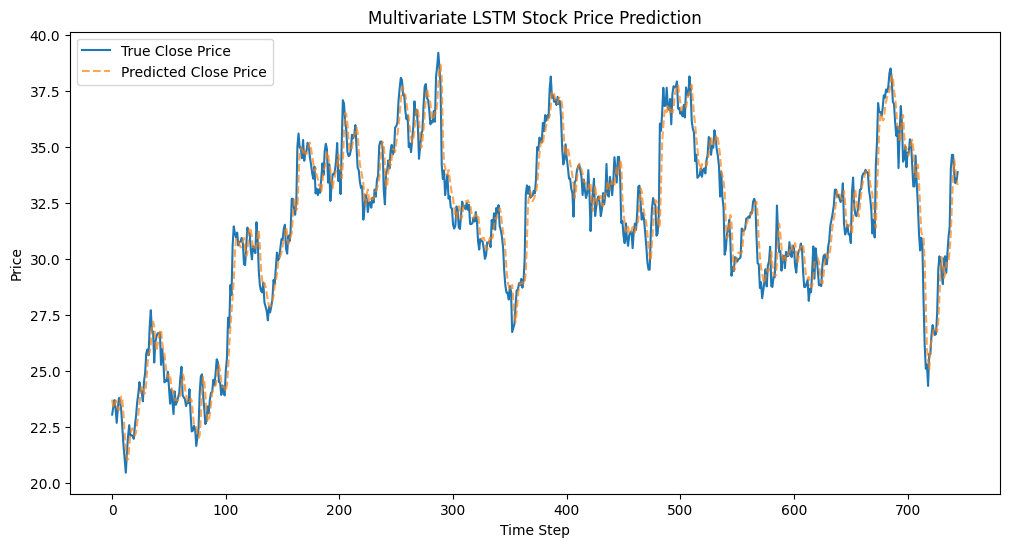

In [15]:
stock_daten.visual_result()

In [170]:
stock_daten.save_training_result()

(745, 1) (745, 1)
(745, 2)


#### save result data

In [171]:
np.savez(f"{stock_daten.model_name}_result.npz", y_test=stock_daten._Y_test_actual, y_pred=stock_daten._Y_pred_actual)

### Run model with saved data

In [162]:
stock = Stock_Model(SYMBOL, HISTORY)

In [89]:
keep_new_test = stock._Y_test_actual
keep_new_pred = stock._Y_pred_actual

In [163]:
stock._Y_test_actual = keep_new_test
stock._Y_pred_actual = keep_new_pred

In [76]:
stock.train_model_with_loaded_data()

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0252 - val_loss: 0.0027
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

In [164]:
stock.save_training_result()

(745, 1) (745, 1)
(745, 2)


In [152]:
stock.evaluate_result(3)

Best delay days:
Mean Squared Error: delay day [2], value: [0.4836052916070396]
Mean Absolute Error: delay day [2], value: [0.5806893904046931]
RMSE: delay day [2], value: [0.6954173506657996]
R2 Score: delay day [2], value: [0.969537856947884]
Best Correct Rate of Prediction of Direction: delay day [1], value [73.49%]


In [153]:
stock.GetDirectionRate(2)

0.7129380053908356

In [155]:
stock.GetConfusionMatrix(1)
stock.GetConfusionMatrix(2)

Accuracy: 0.7348586810228802
Specificity: 0.7142857142857143
Sensitivity: 0.7553763440860215
Precision: 0.7260981912144703
F1 Score: 0.7404479578392622
Accuracy: 0.7129380053908356
Specificity: 0.692722371967655
Sensitivity: 0.7331536388140162
Precision: 0.7046632124352331
F1 Score: 0.7186261558784676


### visual data from markt

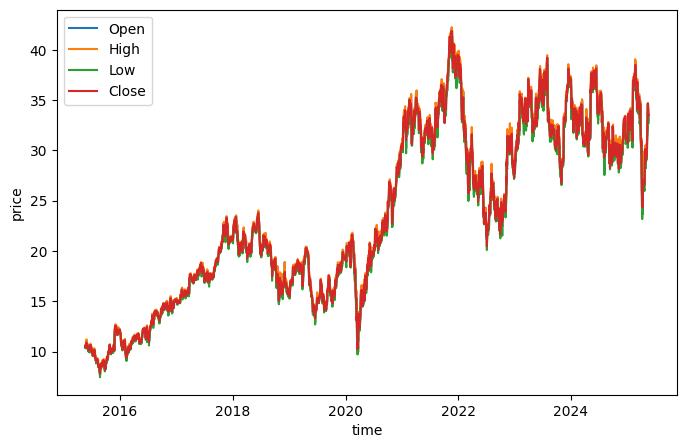

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
fig1 = plt.figure(figsize=(8, 5))
plt.plot(stock_daten.stock_data[stock_daten.features[0][0]], label=stock_daten.features[0][0])
plt.plot(stock_daten.stock_data[stock_daten.features[0][1]], label=stock_daten.features[0][1])
plt.plot(stock_daten.stock_data[stock_daten.features[0][2]], label=stock_daten.features[0][2])
plt.plot(stock_daten.stock_data[stock_daten.features[0][3]], label=stock_daten.features[0][3])
#plt.xlim('2023.01.01', '2023.12.31')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()